<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_CatBoost_StartingPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings

### Installation

In [25]:
!pip install -q catboost shap import_ipynb

### Load Modules

In [115]:
# utils
import os, sys, warnings, itertools
import shap
import import_ipynb
import pandas as pd
import numpy as np
from pprint import pprint
# colab
from google.colab import drive
# catboost
import catboost
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import (get_roc_curve,
                            get_fpr_curve,
                            get_fnr_curve,
                            select_threshold)
from catboost.datasets import amazon
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             classification_report,
                             precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             precision_recall_curve,
                             PrecisionRecallDisplay,
                             roc_auc_score,
                             roc_curve
                             )
# vis
import matplotlib.pyplot as plt

In [27]:
np.set_printoptions(precision=4)
print("NumPy version:", np.__version__)
print("CatBoost version:", catboost.__version__)

NumPy version: 1.26.4
CatBoost version: 1.2.7


### Setup

In [28]:
warnings.filterwarnings("ignore")

In [29]:
%matplotlib inline

In [30]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
working_path = os.path.abspath(os.path.join("/content/drive/MyDrive/Jupyter Notebooks/"))
os.chdir(working_path)

In [32]:
# load MachineLearningUtils
from MachineLearningUtils import *

## Load Data

In [33]:
train_df, test_df = amazon()
print("train data frame shape: ", train_df.shape)
print("test data frame shape: ", test_df.shape)

train data frame shape:  (32769, 10)
test data frame shape:  (58921, 10)


## Understand Data

In [34]:
display_df(train_df)

Dataframe:  
num_rows = 32,769 
num_cols = 10


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [35]:
summarize_columns(train_df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,ACTION,int64,0,0.0,2,1,1,1
1,RESOURCE,int64,0,0.0,7518,39353,17183,36724
2,MGR_ID,int64,0,0.0,4243,85475,1540,14457
3,ROLE_ROLLUP_1,int64,0,0.0,128,117961,117961,118219
4,ROLE_ROLLUP_2,int64,0,0.0,177,118300,118343,118220
5,ROLE_DEPTNAME,int64,0,0.0,449,123472,123125,117884
6,ROLE_TITLE,int64,0,0.0,343,117905,118536,117879
7,ROLE_FAMILY_DESC,int64,0,0.0,2358,117906,118536,267952
8,ROLE_FAMILY,int64,0,0.0,67,290919,308574,19721
9,ROLE_CODE,int64,0,0.0,343,117908,118539,117880


## Model Developement

In [36]:
X = train_df.drop(["ACTION"], axis=1)
y = train_df.ACTION

In [37]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [38]:
print("Labels: {}".format(set(y)))
print("Number of zeros and ones are {}, {}, respectively!".format(len(y)-sum(y), sum(y)))

Labels: {0, 1}
Number of zeros and ones are 1897, 30872, respectively!


#### Initial Model

In [39]:
%%time
clf = CatBoostClassifier(iterations=100)
clf.fit(X, y, cat_features=cat_features, verbose=10)
print("Model is fitted: {}".format(clf.is_fitted()))
print("Model parameters: {}".format(clf.get_params()))

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 78.7ms	remaining: 7.79s
10:	learn: 0.1744186	total: 652ms	remaining: 5.27s
20:	learn: 0.1676119	total: 1.13s	remaining: 4.25s
30:	learn: 0.1652446	total: 1.7s	remaining: 3.77s
40:	learn: 0.1633644	total: 2.14s	remaining: 3.07s
50:	learn: 0.1621892	total: 2.58s	remaining: 2.48s
60:	learn: 0.1609164	total: 2.99s	remaining: 1.91s
70:	learn: 0.1594572	total: 3.55s	remaining: 1.45s
80:	learn: 0.1585876	total: 4.07s	remaining: 954ms
90:	learn: 0.1573593	total: 4.5s	remaining: 446ms
99:	learn: 0.1566977	total: 4.91s	remaining: 0us
Model is fitted: True
Model parameters: {'iterations': 100}
CPU times: user 3.91 s, sys: 305 ms, total: 4.22 s
Wall time: 5.64 s


In [40]:
for attr in clf.__dict__:
    print(f"{attr}: {getattr(clf, attr)}")

_init_params: {'iterations': 100}
_object: <_catboost._CatBoost object at 0x7d9ea750cd60>
_is_fitted_: True
_random_seed: 0
_learning_rate: 0.37760400772094727
_tree_count: 100
_n_features_in: 9
_prediction_values_change: [19.986298926989615, 27.451178396157633, 3.419162173149494, 7.6746580672583, 12.301505440210862, 5.183704396742087, 12.591480691632364, 6.268143378006017, 5.123868529853629]


In [51]:
methods = [method for method in dir(clf) if callable(getattr(clf, method))]
pprint(methods)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_base_calc_leaf_indexes',
 '_base_drop_unused_features',
 '_base_eval_metrics',
 '_base_predict',
 '_base_shrink',
 '_base_virtual_ensembles_predict',
 '_calc_fstr',
 '_calc_leaf_indexes',
 '_calc_ostr',
 '_check_is_compatible_loss',
 '_convert_to_asymmetric_representation',
 '_dataset_train_eval_split',
 '_deserialize_model',
 '_eval_metrics',
 '_fit',
 '_get_borders',
 '_get_cat_feature_indices',
 '_get_embedding_feature_indices',
 '_get_float_feature_indices',
 '_get_nan_treatments',
 '_get_params',
 '_get_tags',
 '_get_text_feature_indices',
 '_get_tree_leaf_values',
 '_get_tree_node_to_leaf',
 '_get_tree_splits',
 '_get_

Confusion matrix, without normalization


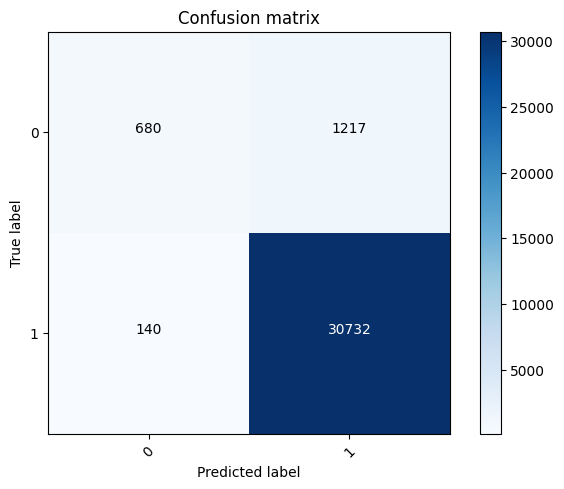

In [17]:
predictions = np.argmax(clf.predict_proba(X), axis=1)
cm = confusion_matrix(y_true=y, y_pred=predictions, labels=clf.classes_)
plot_conf_matrix(cm, classes=clf.classes_, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues)

### Model Using Pool Data Structure

In [79]:
%%time
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(data=X_validation, label=y_validation, cat_features=cat_features)
model = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function="Logloss")
model.fit(train_pool, eval_set=validation_pool, verbose=10)
print("Model is fitted: {}".format(model.is_fitted()))
print("Model parameters: {}".format(model.get_params()))

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 58.3ms	remaining: 5.77s
10:	learn: 0.3023734	test: 0.3000875	best: 0.3000875 (10)	total: 427ms	remaining: 3.45s
20:	learn: 0.2224740	test: 0.2182753	best: 0.2182753 (20)	total: 692ms	remaining: 2.6s
30:	learn: 0.1915694	test: 0.1843315	best: 0.1843315 (30)	total: 1.06s	remaining: 2.35s
40:	learn: 0.1810866	test: 0.1723486	best: 0.1723486 (40)	total: 1.45s	remaining: 2.09s
50:	learn: 0.1766195	test: 0.1650760	best: 0.1650760 (50)	total: 1.77s	remaining: 1.7s
60:	learn: 0.1743201	test: 0.1620310	best: 0.1620310 (60)	total: 2.21s	remaining: 1.41s
70:	learn: 0.1727259	test: 0.1604053	best: 0.1604053 (70)	total: 2.7s	remaining: 1.1s
80:	learn: 0.1717055	test: 0.1592850	best: 0.1592850 (80)	total: 3.17s	remaining: 744ms
90:	learn: 0.1709790	test: 0.1587529	best: 0.1587529 (90)	total: 3.69s	remaining: 365ms
99:	learn: 0.1704454	test: 0.1585780	best: 0.1584908 (96)	total: 3.98s	remaining: 0us

bestTest = 0.1584908358
bestIteration 

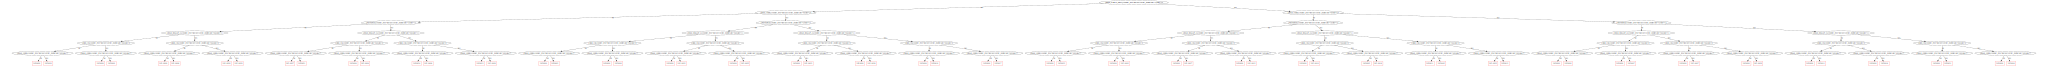

In [91]:
model.plot_tree(tree_idx=model.best_iteration_, pool=validation_pool)

### Model with Custom Loss Functions

In [20]:
%%time
X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                                y,
                                                                test_size=0.2,
                                                                random_state=0)
train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)
validation_pool = Pool(data=X_validation,
                       label=y_validation,
                       cat_features=cat_features)
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           custom_loss=["AUC", "Accuracy", "Logloss"],
                           train_dir="catboost_dir")
model.fit(train_pool,
          eval_set=validation_pool,
          verbose=10,
          plot=False)
print("Model is fitted: {}".format(model.is_fitted()))
print("Model parameters: {}".format(model.get_params()))
print("Tree count:" + str(model.tree_count_))
catboost.MetricVisualizer(["catboost_dir"]).start()

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 70.2ms	remaining: 6.95s
10:	learn: 0.3023734	test: 0.3000875	best: 0.3000875 (10)	total: 478ms	remaining: 3.86s
20:	learn: 0.2224740	test: 0.2182753	best: 0.2182753 (20)	total: 958ms	remaining: 3.6s
30:	learn: 0.1915694	test: 0.1843315	best: 0.1843315 (30)	total: 1.48s	remaining: 3.28s
40:	learn: 0.1810866	test: 0.1723486	best: 0.1723486 (40)	total: 2.03s	remaining: 2.92s
50:	learn: 0.1766195	test: 0.1650760	best: 0.1650760 (50)	total: 2.44s	remaining: 2.35s
60:	learn: 0.1743201	test: 0.1620310	best: 0.1620310 (60)	total: 2.94s	remaining: 1.88s
70:	learn: 0.1727259	test: 0.1604053	best: 0.1604053 (70)	total: 3.38s	remaining: 1.38s
80:	learn: 0.1717055	test: 0.1592850	best: 0.1592850 (80)	total: 3.93s	remaining: 923ms
90:	learn: 0.1709790	test: 0.1587529	best: 0.1587529 (90)	total: 4.29s	remaining: 425ms
99:	learn: 0.1704454	test: 0.1585780	best: 0.1584908 (96)	total: 4.73s	remaining: 0us

bestTest = 0.1584908358
bestIterati

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 3.71 s, sys: 370 ms, total: 4.08 s
Wall time: 9.15 s


In [74]:
model.best_iteration_

96

In [67]:
evals = model.get_evals_result()
df = pd.DataFrame.from_dict({(i,j): evals[i][j]
                           for i in evals.keys()
                           for j in evals[i].keys()},
                          orient='index')
df = df.T
display(df)

,"(learn, Accuracy)","(learn, Logloss)","(validation, Accuracy)","(validation, Logloss)","(validation, AUC)"
0,0.941827,0.618949,0.943241,0.618779,0.529341
1,0.941827,0.558541,0.943241,0.557974,0.561574
2,0.941827,0.508329,0.943241,0.507531,0.564231
3,0.941827,0.466128,0.943241,0.464988,0.580120
4,0.941827,0.430528,0.943241,0.429112,0.594306
...,...,...,...,...,...
95,0.946672,0.170725,0.945682,0.158566,0.857699
96,0.946824,0.170600,0.945835,0.158491,0.857822
97,0.946824,0.170555,0.945835,0.158509,0.857760
98,0.946939,0.170472,0.945835,0.158533,0.857623


### Model with CV to Find Optimum Iteration

In [92]:
%%time
params = {
    "loss_function": "Logloss",
    "iterations": 80,
    "custom_loss": "AUC",
    "learning_rate": 0.1
    }
cv_data = cv(params=params,
             pool=train_pool,
             fold_count=5,
             shuffle=True,
             partition_random_seed=0,
             plot=True,
             verbose=20,
             stratified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5812867	test: 0.5812871	best: 0.5812871 (0)	total: 59.4ms	remaining: 4.69s
20:	learn: 0.1932578	test: 0.1849005	best: 0.1849005 (20)	total: 1.65s	remaining: 4.63s
40:	learn: 0.1760028	test: 0.1652442	best: 0.1652442 (40)	total: 4.15s	remaining: 3.95s
60:	learn: 0.1709795	test: 0.1622999	best: 0.1622999 (60)	total: 5.64s	remaining: 1.76s
79:	learn: 0.1687357	test: 0.1613221	best: 0.1612996 (78)	total: 7.11s	remaining: 0us

bestTest = 0.1612996284
bestIteration = 78

Training on fold [1/5]
0:	learn: 0.5812726	test: 0.5812835	best: 0.5812835 (0)	total: 72.4ms	remaining: 5.72s
20:	learn: 0.1924537	test: 0.1863979	best: 0.1863979 (20)	total: 1.01s	remaining: 2.83s
40:	learn: 0.1761818	test: 0.1680655	best: 0.1680655 (40)	total: 2.27s	remaining: 2.16s
60:	learn: 0.1710659	test: 0.1634331	best: 0.1634331 (60)	total: 3.58s	remaining: 1.12s
79:	learn: 0.1682807	test: 0.1617425	best: 0.1617425 (79)	total: 4.73s	remaining: 0us

bestTest = 0.1617424602
bestIterat

In [93]:
cv_data

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.581285,0.000002,0.581281,0.000007,0.496175,0.014042
1,1,0.496233,0.000040,0.496221,0.000035,0.519188,0.016686
2,2,0.430985,0.000034,0.430972,0.000030,0.519188,0.016686
3,3,0.381694,0.000227,0.381684,0.000312,0.532236,0.022482
4,4,0.342926,0.000777,0.342961,0.000705,0.580106,0.031891
...,...,...,...,...,...,...,...
75,75,0.162464,0.002647,0.168834,0.000696,0.848693,0.011092
76,76,0.162407,0.002687,0.168669,0.000718,0.848859,0.011107
77,77,0.162370,0.002678,0.168495,0.000740,0.848964,0.010991
78,78,0.162343,0.002694,0.168353,0.000701,0.849018,0.010853


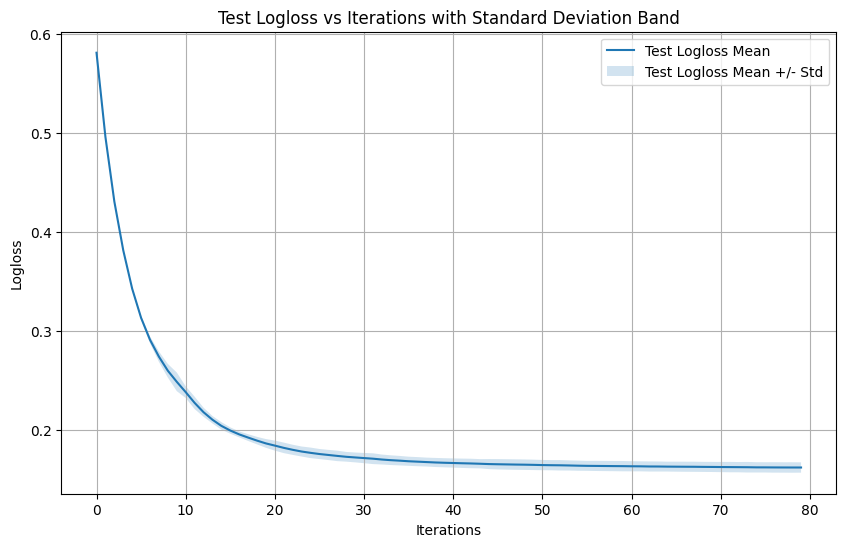

In [96]:
iterations = cv_data['iterations']
test_logloss_mean = cv_data['test-Logloss-mean']
test_logloss_std = cv_data['test-Logloss-std']

plt.figure(figsize=(10, 6))
plt.plot(iterations, test_logloss_mean, label='Test Logloss Mean')
plt.fill_between(iterations,
                 test_logloss_mean - 1.96 * test_logloss_std,
                 test_logloss_mean + 1.96 * test_logloss_std,
                 alpha=0.2,
                 label='Test Logloss Mean +/- Std')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Test Logloss vs Iterations with Standard Deviation Band')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_itr = np.argmin(cv_data["test-Logloss-mean"])
print("Best validation logloss: {:.4f}±{:.4f} on step {}".format(best_value, cv_data["test-Logloss-std"][best_itr], best_itr))

Best validation logloss: 0.1623±0.0027 on step 79


### GridSearchCV Model

In [102]:
%%time
param_grid = {
    "loss_function": ["Logloss"],
    "iterations": [10, 20],
    "learning_rate": [0.1, 0.2, 0.3],
    "depth": [6, 8, 10]
    }

clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
    )
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6192124	total: 24.5ms	remaining: 220ms
9:	learn: 0.3176935	total: 194ms	remaining: 0us
0:	learn: 0.6191226	total: 19.1ms	remaining: 172ms
9:	learn: 0.3174645	total: 193ms	remaining: 0us
0:	learn: 0.5529618	total: 20.1ms	remaining: 181ms
9:	learn: 0.2340109	total: 88.1ms	remaining: 0us
0:	learn: 0.5528028	total: 8.05ms	remaining: 72.5ms
9:	learn: 0.2320338	total: 73.1ms	remaining: 0us
0:	learn: 0.4942204	total: 9.68ms	remaining: 87.1ms
9:	learn: 0.2021815	total: 73.6ms	remaining: 0us
0:	learn: 0.4940117	total: 11.9ms	remaining: 107ms
9:	learn: 0.1976516	total: 82.4ms	remaining: 0us
0:	learn: 0.6192124	total: 8.94ms	remaining: 170ms
19:	learn: 0.2347140	total: 108ms	remaining: 0us
0:	learn: 0.6191226	total: 7.34ms	remaining: 140ms
19:	learn: 0.2350162	total: 119ms	remaining: 0us
0:	learn: 0.5529618	total: 8.52ms	remaining: 162ms
19:	learn: 0.1928163	total: 151ms	remaining: 0us
0:	learn: 0.5528028	total: 7.39ms	remaining: 140ms
19:	learn: 0.1877890	total: 176ms	remaining: 0us


{'iterations': 20,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'depth': 8,
 'learning_rate': 0.3,
 'loss_function': 'Logloss'}

Confusion matrix, without normalization


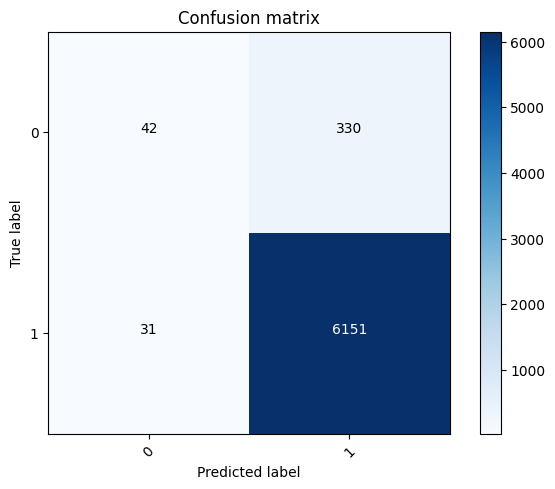

In [113]:
y_pred = grid_search.predict(X_validation)
cm = confusion_matrix(y_true=y_validation, y_pred=y_pred, labels=clf.classes_)
plot_conf_matrix(cm, classes=grid_search.classes_, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues)

In [124]:
def evaluate_clf(y_true, y_pred, average='weighted'):
  """
  Computes accuracy, precision, recall, and F1-score for multi-class classification.

  Args:
    y_true: True labels.
    y_pred: Predicted labels.
    average: Averaging method for precision, recall, and F1-score.
             Default is 'weighted' to account for class imbalance.
             Other options include 'micro', 'macro', and None.

  Returns:
    None (prints the metrics)
  """

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average=average)
  recall = recall_score(y_true, y_pred, average=average)
  f1 = f1_score(y_true, y_pred, average=average)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")

In [123]:
evaluate_clf(y_validation, y_pred)

Accuracy: 0.9449
Precision: 0.7622
Recall: 0.5539
F1-score: 0.5801


### Model with Early Stopping

In [128]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20,
    eval_metric="AUC"
    )
model.fit(train_pool, eval_set=validation_pool, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5509439	best: 0.5509439 (0)	total: 117ms	remaining: 23.2s
10:	test: 0.8847697	best: 0.8849074 (9)	total: 1.46s	remaining: 25.1s
20:	test: 0.8948623	best: 0.8954526 (18)	total: 3.62s	remaining: 30.9s
30:	test: 0.8956361	best: 0.8956361 (30)	total: 5.84s	remaining: 31.8s
40:	test: 0.8965850	best: 0.8965982 (33)	total: 7.62s	remaining: 29.5s
50:	test: 0.9001719	best: 0.9001719 (50)	total: 9.04s	remaining: 26.4s
60:	test: 0.8991275	best: 0.9001719 (50)	total: 10.4s	remaining: 23.8s
70:	test: 0.8981121	best: 0.9001719 (50)	total: 11.8s	remaining: 21.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9001719352
bestIteration = 50

Shrink model to first 51 iterations.


In [129]:
print(model.tree_count_)

51


## Model Analysis

In [130]:
clf = CatBoostClassifier(iterations=200, learning_rate=0.03)
clf.fit(train_pool, verbose=50)
print("prediction:\n", clf.predict(X_validation))
print("prediction probabilities:\n", clf.predict_proba(X_validation))

0:	learn: 0.6569432	total: 244ms	remaining: 48.5s
50:	learn: 0.1937127	total: 6.16s	remaining: 18s
100:	learn: 0.1652233	total: 13.1s	remaining: 12.9s
150:	learn: 0.1587891	total: 19s	remaining: 6.16s
199:	learn: 0.1551770	total: 22.2s	remaining: 0us
prediction:
 [1 1 1 ... 1 1 1]
prediction probabilities:
 [[0.0291 0.9709]
 [0.0204 0.9796]
 [0.0101 0.9899]
 ...
 [0.0281 0.9719]
 [0.046  0.954 ]
 [0.0244 0.9756]]


In [171]:
print(clf.predict_proba([X.iloc[1,:]]))
print(clf.predict_proba([X.iloc[87,:]]))

[[0.0121 0.9879]]
[[0.0108 0.9892]]


In [133]:
curve = get_roc_curve(clf, validation_pool)
(fpr, tpr, thresholds) = curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

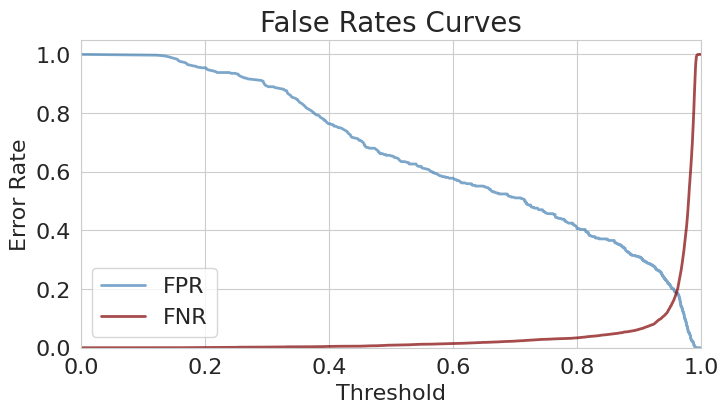

In [138]:
plt.figure(figsize=(8,4))
style = {"alpha": 0.7, "lw": 2}
plt.plot(thresholds, fpr, color="steelblue", label="FPR", **style)
plt.plot(thresholds, fnr, color="maroon", label="FNR", **style)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.title("False Rates Curves", fontsize=20)
plt.legend(loc="lower left", fontsize=16)

In [143]:
print(select_threshold(clf, validation_pool, FNR=0.01))
print(select_threshold(clf, validation_pool, FPR=0.01))

0.5265607057995692
0.9887115638534019


In [150]:
threshold = select_threshold(model, validation_pool, FPR=0.01)
print(f"Optimal threshold for FPR=0.01: {threshold}")

Optimal threshold for FPR=0.01: 0.9925726593341107


In [151]:
clf_probabilities = clf.predict_proba(X_validation)[:, 1]
predictions = (clf_probabilities >= threshold).astype(int)

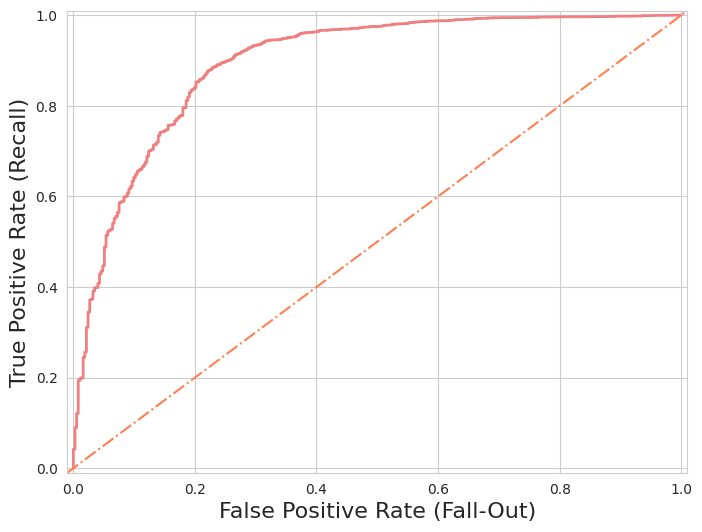

In [142]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "-", linewidth=2, label=label, color="lightcoral",
             markersize=4, markerfacecolor="white")
    plt.plot([-0.01, 1.01], [-0.01, 1.01], "coral", linestyle="-.")
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [165]:
metrics = clf.eval_metrics(
    data=validation_pool,
    metrics=["Logloss", "AUC"],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
    )
print("AUC values:\n{}".format(np.array(metrics["AUC"])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC values:
[0.5509 0.6273 0.6273 0.6279 0.6264 0.6262 0.6579 0.6579 0.6581 0.6581
 0.6561 0.656  0.6562 0.6535 0.6534 0.6541 0.6562 0.6544 0.6576 0.6642
 0.677  0.6842 0.7073 0.7142 0.7345 0.7412 0.7427 0.7441 0.7732 0.7791
 0.7991 0.8019 0.8019 0.8064 0.8157 0.8157 0.8211 0.8223 0.8263 0.8302
 0.8314 0.8342 0.837  0.8382 0.84   0.8405 0.8421 0.8425 0.8444 0.8467
 0.8471 0.846  0.846  0.8464 0.8466 0.8469 0.847  0.8475 0.8477 0.8479
 0.8495 0.8501 0.8503 0.851  0.8514 0.8515 0.8528 0.8531 0.8537 0.8541
 0.8576 0.8591 0.8619 0.8639 0.8659 0.8673 0.8691 0.8702 0.871  0.8715
 0.8721 0.8726 0.8729 0.8739 0.8748 0.8756 0.8758 0.877  0.8775 0.8781
 0.8787 0.8793 0.8794 0.8797 0.8801 0.8808 0.8818 0.8825 0.8835 0.8842
 0.8851 0.8856 0.886  0.8866 0.8872 0.8873 0.8873 0.8875 0.8876 0.888
 0.8884 0.8885 0.8887 0.8886 0.8888 0.8892 0.8892 0.8898 0.89   0.8902
 0.8903 0.8904 0.8906 0.8909 0.8912 0.8913 0.8915 0.8914 0.8915 0.8916
 0.8918 0.8919 0.892  0.892  0.8919 0.892  0.8921 0.8921 0.8922 0.

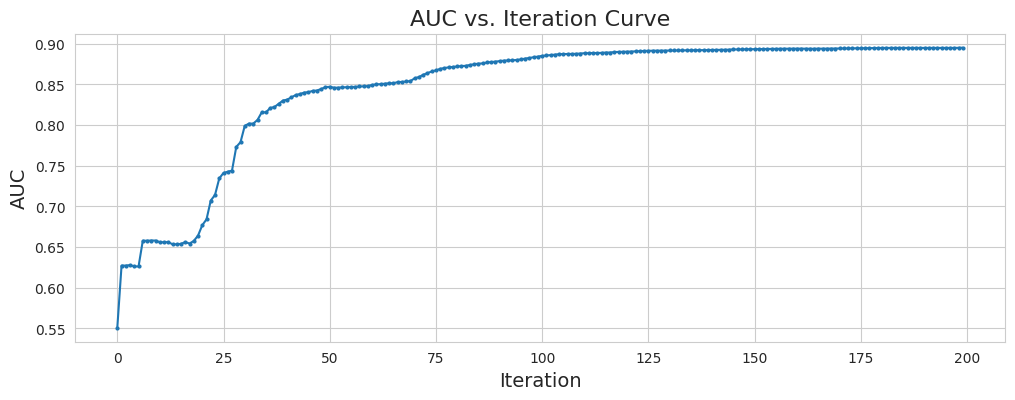

In [169]:
plt.figure(figsize=(12, 4))
plt.plot(metrics["AUC"], "o-", markersize=2)
plt.title("AUC vs. Iteration Curve", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("AUC", fontsize=14)
plt.grid(True)
plt.show()

In [172]:
np.array(clf.get_feature_importance(prettified=True))

array([['RESOURCE', 22.92400608170266],
       ['MGR_ID', 17.21196784882042],
       ['ROLE_DEPTNAME', 16.202495581093604],
       ['ROLE_ROLLUP_2', 10.877684302919873],
       ['ROLE_TITLE', 9.654753851767108],
       ['ROLE_FAMILY_DESC', 8.645750962754958],
       ['ROLE_CODE', 5.817048641627578],
       ['ROLE_FAMILY', 4.763477365274886],
       ['ROLE_ROLLUP_1', 3.9028153640387533]], dtype=object)

In [173]:
np.array(clf.get_feature_importance(train_pool, "LossFunctionChange", prettified=True))

array([['RESOURCE', 0.021309777399393458],
       ['MGR_ID', 0.015592322688232385],
       ['ROLE_DEPTNAME', 0.009610203122561153],
       ['ROLE_FAMILY_DESC', 0.008324709730521051],
       ['ROLE_TITLE', 0.008193546395980121],
       ['ROLE_ROLLUP_2', 0.007040966898883023],
       ['ROLE_CODE', 0.0016782469192984976],
       ['ROLE_FAMILY', -6.332962350000018e-05],
       ['ROLE_ROLLUP_1', -0.000141922643884083]], dtype=object)

In [176]:
shap_values = clf.get_feature_importance(validation_pool, "ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [177]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation.iloc[1,:])

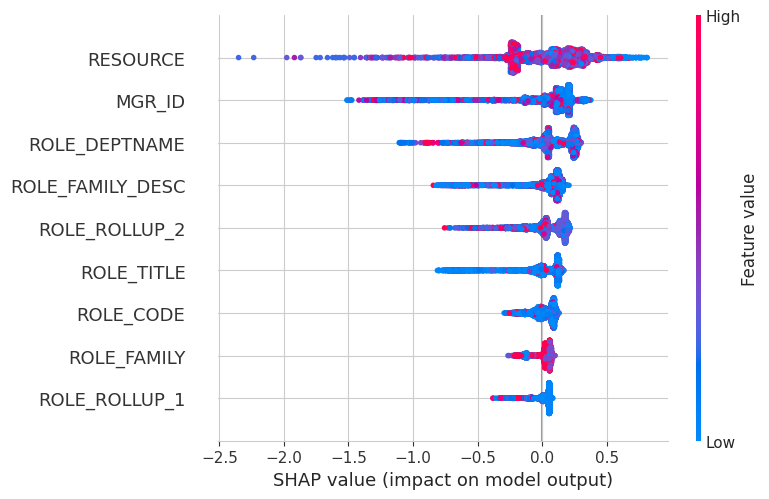

In [178]:
shap.summary_plot(shap_values, X_validation)

### Model Tunning

In [183]:
%%time
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
    )

model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1min 1s, sys: 1.54 s, total: 1min 2s
Wall time: 48.6 s


In [182]:
%%time
model = CatBoostClassifier(
    boosting_type="Plain",
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.05,
    bootstrap_type="Bernoulli",
    subsample=0.5
    )

model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1.94 s, sys: 220 ms, total: 2.16 s
Wall time: 4.19 s


In [181]:
%%time
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
    )

model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 2.32 s, sys: 226 ms, total: 2.55 s
Wall time: 3.43 s
